In [1]:
#kutuphanelerin import islemi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import requests
import csv
from wordcloud import WordCloud
%matplotlib inline
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
#from google.colab import auth
from oauth2client.client import GoogleCredentials
import plotly.graph_objects as go
from datetime import datetime

In [2]:
# 3M satır datanın 1M bölümünü kullanmak için dataframe'e load ediyoruz
df2 = pd.DataFrame([])
for df in pd.read_csv('D://sehir_unv_ders_notlari//bitirme_projesi//data//US_Accidents_Dec19.csv', iterator=True, chunksize=10000):
    df2 = df2.append(df)    
    if (df2.shape[0] >= 1000000):
        break
df2.shape

(1000000, 49)

In [3]:
#ilk on satırın gosterilmesi
df2.head(10)

ID    Source    TMC  Severity           Start_Time             End_Time  \
0   A-1  MapQuest  201.0         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1   A-2  MapQuest  201.0         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2   A-3  MapQuest  201.0         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3   A-4  MapQuest  201.0         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4   A-5  MapQuest  201.0         2  2016-02-08 07:39:07  2016-02-08 08:09:07   
5   A-6  MapQuest  201.0         3  2016-02-08 07:44:26  2016-02-08 08:14:26   
6   A-7  MapQuest  201.0         2  2016-02-08 07:59:35  2016-02-08 08:29:35   
7   A-8  MapQuest  201.0         3  2016-02-08 07:59:58  2016-02-08 08:29:58   
8   A-9  MapQuest  201.0         2  2016-02-08 08:00:40  2016-02-08 08:30:40   
9  A-10  MapQuest  201.0         3  2016-02-08 08:10:04  2016-02-08 08:40:04   

   Start_Lat  Start_Lng  End_Lat  End_Lng  ...  Roundabout Station   Stop  \
0  39.865147 -84.058723      NaN      NaN  ...       False   False  False   
1  39.928059 -82.831184      NaN      NaN  ...       False   False  False   
2  39.063148 -84.032608      NaN      NaN  ...       False   False  False   
3  39.747753 -84.205582      NaN      NaN  ...       False   False  False   
4  39.627781 -84.188354      NaN      NaN  ...       False   False  False   
5  40.100590 -82.925194      NaN      NaN  ...       False   False  False   
6  39.758274 -84.230507      NaN      NaN  ...       False   False  False   
7  39.770382 -84.194901      NaN      NaN  ...       False   False  False   
8  39.778061 -84.172005      NaN      NaN  ...       False   False  False   
9  40.100590 -82.925194      NaN      NaN  ...       False   False  False   

  Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset Civil_Twilight  \
0           False          False        False          Night          Night   
1           False          False        False          Night          Night   
2           False           True        False          Night          Night   
3           False          False        False          Night            Day   
4           False           True        False            Day            Day   
5           False          False        False            Day            Day   
6           False          False        False            Day            Day   
7           False          False        False            Day            Day   
8           False          False        False            Day            Day   
9           False          False        False            Day            Day   

  Nautical_Twilight Astronomical_Twilight  
0             Night                 Night  
1             Night                   Day  
2               Day                   Day  
3               Day                   Day  
4               Day                   Day  
5               Day                   Day  
6               Day                   Day  
7               Day                   Day  
8               Day                   Day  
9               Day                   Day  

[10 rows x 49 columns]

In [4]:
#satir ve sutun gosterimi
df2.shape

(1000000, 49)

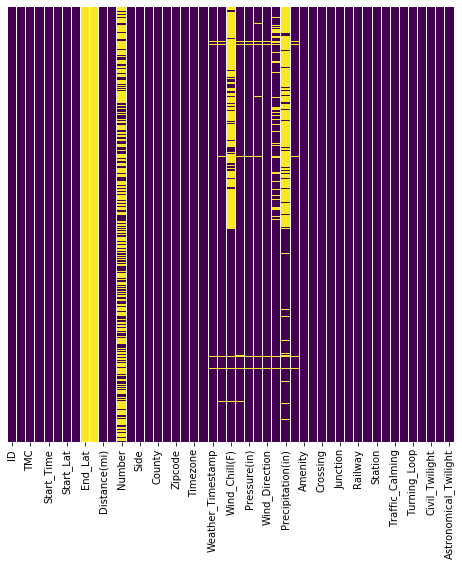

In [5]:
#eksik degerlerin grafiksel gosterimi
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis') # missing value check

In [6]:
#kolonlardaki null değerlerin gösterilmesi
for i in range(len(df.columns)):
    x = df2.columns[i]
    print(x, '-', df[df[x].isnull() == True].shape)

ID - (0, 49)
Source - (0, 49)
TMC - (0, 49)
Severity - (0, 49)
Start_Time - (0, 49)
End_Time - (0, 49)
Start_Lat - (0, 49)
Start_Lng - (0, 49)
End_Lat - (10000, 49)
End_Lng - (10000, 49)
Distance(mi) - (0, 49)
Description - (0, 49)
Number - (5685, 49)
Street - (0, 49)
Side - (0, 49)
City - (0, 49)
County - (0, 49)
State - (0, 49)
Zipcode - (0, 49)
Country - (0, 49)
Timezone - (6, 49)
Airport_Code - (16, 49)
Weather_Timestamp - (47, 49)
Temperature(F) - (75, 49)
Wind_Chill(F) - (145, 49)
Humidity(%) - (83, 49)
Pressure(in) - (55, 49)
Visibility(mi) - (80, 49)
Wind_Direction - (123, 49)
Wind_Speed(mph) - (121, 49)
Precipitation(in) - (348, 49)
Weather_Condition - (74, 49)
Amenity - (0, 49)
Bump - (0, 49)
Crossing - (0, 49)
Give_Way - (0, 49)
Junction - (0, 49)
No_Exit - (0, 49)
Railway - (0, 49)
Roundabout - (0, 49)
Station - (0, 49)
Stop - (0, 49)
Traffic_Calming - (0, 49)
Traffic_Signal - (0, 49)
Turning_Loop - (0, 49)
Sunrise_Sunset - (0, 49)
Civil_Twilight - (0, 49)
Nautical_Twilight

In [7]:
#Eksik değerleri mean ve median ile dolduran fonksiyonlar
def impute_median(col):
    return col.fillna(col.median())

def impute_mean(col):
    return col.fillna(col.mean())

In [8]:
df2.End_Lat = df2['End_Lat'].transform(impute_median)
df2.End_Lng = df2['End_Lng'].transform(impute_median)
df2.TMC = df2['TMC'].transform(impute_median)
df2.Number = df2['Number'].transform(impute_mean)
df2['Temperature(F)'] = df2['Temperature(F)'].transform(impute_median)
df2['Wind_Chill(F)'] = df2['Wind_Chill(F)'].transform(impute_median)
df2['Humidity(%)'] = df2['Humidity(%)'].transform(impute_median)
df2['Pressure(in)'] = df2['Pressure(in)'].transform(impute_median)
df2['Visibility(mi)'] = df2['Visibility(mi)'].transform(impute_median)
df2['Wind_Speed(mph)'] = df2['Wind_Speed(mph)'].transform(impute_median)
df2['Precipitation(in)'] = df2['Precipitation(in)'].transform(impute_median)
df2.isnull().sum()

ID                             0
Source                         0
TMC                            0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  1000000
End_Lng                  1000000
Distance(mi)                   0
Description                    0
Number                         0
Street                         0
Side                           0
City                          32
County                         0
State                          0
Zipcode                      135
Country                        0
Timezone                     572
Airport_Code                1044
Weather_Timestamp           9443
Temperature(F)                 0
Wind_Chill(F)                  0
Humidity(%)                    0
Pressure(in)                   0
Visibility(mi)                 0
Wind_Direction             14573
Wind_Speed(mph)                0
Precipitat

In [9]:
#Kategorik değişkenlerin mode değerleri
print(df2['Weather_Condition'].mode())
print(df2['Astronomical_Twilight'].mode())
print(df2['Nautical_Twilight'].mode())
print(df2['Weather_Timestamp'].mode())
print(df2['Civil_Twilight'].mode())
print(df2['Sunrise_Sunset'].mode())
print(df2['Wind_Direction'].mode())
print(df2['City'].mode())
print(df2['Zipcode'].mode())
print(df2['Airport_Code'].mode())
print(df2['Timezone'].mode())
print(df2['Description'].mode())

0    Fair
dtype: object
0    Day
dtype: object
0    Day
dtype: object
0    2019-09-17 07:53:00
dtype: object
0    Day
dtype: object
0    Day
dtype: object
0    CALM
dtype: object
0    Houston
dtype: object
0    91706
dtype: object
0    KMCJ
dtype: object
0    US/Eastern
dtype: object
0    Accident on I-85 Southbound at Exit 54 Pelham Rd.
dtype: object


In [10]:
#kategorik değişkenlerdeki null değerlerin mode ile değişimi
df2['Weather_Condition'].fillna(str(df2['Weather_Condition'].mode().values[0]), inplace=True)
df2['Astronomical_Twilight'].fillna(str(df2['Astronomical_Twilight'].mode().values[0]), inplace=True)
df2['Nautical_Twilight'].fillna(str(df2['Nautical_Twilight'].mode().values[0]), inplace=True)
df2['Weather_Timestamp'].fillna(str(df2['Weather_Timestamp'].mode().values[0]), inplace=True)
df2['Weather_Timestamp'] = pd.to_datetime(df2['Weather_Timestamp'])
df2['Civil_Twilight'].fillna(str(df2['Civil_Twilight'].mode().values[0]), inplace=True)
df2['City'].fillna(str(df2['City'].mode().values[0]), inplace=True)
df2['Sunrise_Sunset'].fillna(str(df2['Sunrise_Sunset'].mode().values[0]), inplace=True)
df2['Wind_Direction'].fillna(str(df2['Wind_Direction'].mode().values[0]), inplace=True)
df2['Zipcode'].fillna(str(df2['Zipcode'].mode().values[0]), inplace=True)
df2['Airport_Code'].fillna(str(df2['Airport_Code'].mode().values[0]), inplace=True)
df2['Timezone'].fillna(str(df2['Timezone'].mode().values[0]), inplace=True)
df2['Description'].fillna(str(df2['Description'].mode().values[0]), inplace=True)
df2.isnull().sum()

ID                             0
Source                         0
TMC                            0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  1000000
End_Lng                  1000000
Distance(mi)                   0
Description                    0
Number                         0
Street                         0
Side                           0
City                           0
County                         0
State                          0
Zipcode                        0
Country                        0
Timezone                       0
Airport_Code                   0
Weather_Timestamp              0
Temperature(F)                 0
Wind_Chill(F)                  0
Humidity(%)                    0
Pressure(in)                   0
Visibility(mi)                 0
Wind_Direction                 0
Wind_Speed(mph)                0
Precipitat

In [11]:
df2.drop(['End_Lat', 'End_Lng', 'Number', 'Wind_Chill(F)','Precipitation(in)'], axis=1, inplace=True)
df2.dropna(axis=0, inplace=True)

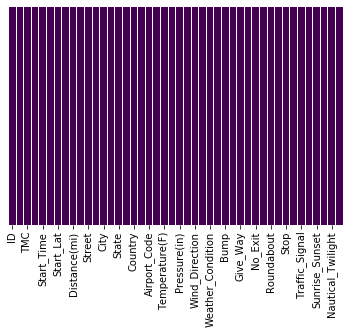

In [12]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis') # OK!!!, eksik veri kalmadi.

In [13]:
df2.isnull().any().sum() #OK

0

In [14]:
#numerik sütunların istatistikleri
df2.describe()

TMC        Severity       Start_Lat       Start_Lng  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       208.821542        2.339867       36.018412      -95.040385   
std         21.378382        0.482182        4.906633       17.185961   
min        200.000000        1.000000       24.555269     -124.484421   
25%        201.000000        2.000000       32.909163     -117.254066   
50%        201.000000        2.000000       35.202011      -90.123672   
75%        201.000000        3.000000       40.078720      -80.893776   
max        406.000000        4.000000       49.002201      -67.841858   

         Distance(mi)  Temperature(F)     Humidity(%)    Pressure(in)  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.155195       65.889606       65.223140       29.661367   
std          1.327107       17.051261       21.411256        0.832580   
min          0.000000      -77.800000        1.000000        0.120000   
25%          0.000000       55.400000       50.000000       29.520000   
50%          0.000000       68.000000       67.000000       29.900000   
75%          0.010000       78.100000       83.000000       30.040000   
max        183.119995      167.000000      100.000000       33.040000   

       Visibility(mi)  Wind_Speed(mph)  
count  1000000.000000   1000000.000000  
mean         9.237272         7.766337  
std          2.307765         5.089905  
min          0.000000         0.000000  
25%         10.000000         5.000000  
50%         10.000000         7.000000  
75%         10.000000        10.000000  
max        111.000000       822.800000

In [15]:
#kolonların gosterilmesi
df2.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Description', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

In [16]:
#data tiplerinin gosterimi
df2.dtypes

ID                               object
Source                           object
TMC                             float64
Severity                          int64
Start_Time                       object
End_Time                         object
Start_Lat                       float64
Start_Lng                       float64
Distance(mi)                    float64
Description                      object
Street                           object
Side                             object
City                             object
County                           object
State                            object
Zipcode                          object
Country                          object
Timezone                         object
Airport_Code                     object
Weather_Timestamp        datetime64[ns]
Temperature(F)                  float64
Humidity(%)                     float64
Pressure(in)                    float64
Visibility(mi)                  float64
Wind_Direction                   object


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 44 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   ID                     1000000 non-null  object        
 1   Source                 1000000 non-null  object        
 2   TMC                    1000000 non-null  float64       
 3   Severity               1000000 non-null  int64         
 4   Start_Time             1000000 non-null  object        
 5   End_Time               1000000 non-null  object        
 6   Start_Lat              1000000 non-null  float64       
 7   Start_Lng              1000000 non-null  float64       
 8   Distance(mi)           1000000 non-null  float64       
 9   Description            1000000 non-null  object        
 10  Street                 1000000 non-null  object        
 11  Side                   1000000 non-null  object        
 12  City                   100000

In [18]:
#Veri setlerinin data tiplerine göre ayrılması
dtype_df = df2.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

Column Type  Count
0           int64      1
1         float64      9
2  datetime64[ns]      1
3            bool     13
4          object     20

In [19]:
df2.shape

(1000000, 44)

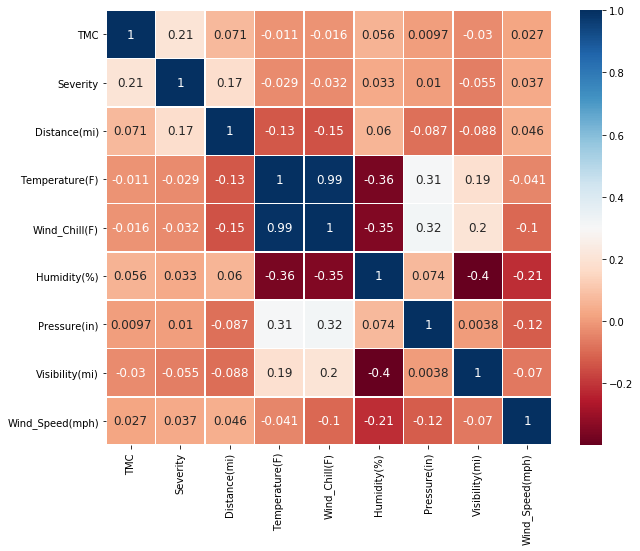

In [20]:
#Korelasyon matrisi
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig=sns.heatmap(df[['TMC','Severity','Distance(mi)', 'Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)',
                    'Visibility(mi)','Wind_Speed(mph)']].corr(),annot=True, linewidths=0.5, annot_kws={'size':12}, linecolor='w', cmap='RdBu')

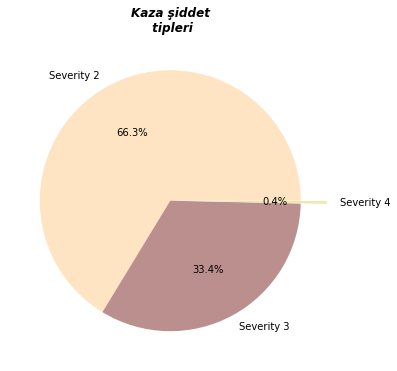

In [21]:
#Kaza şiddeti dağılımları
df_sev = df2.groupby('Severity').size()
df_sev = df_sev[[2,3,4]]
cols = ['bisque', 'rosybrown', 'palegoldenrod']
cases = ['Severity 2','Severity 3','Severity 4']
plt.figure(figsize=(10,6))
plt.pie(df_sev,
        colors = cols,
        labels= cases,
        explode = (0,0,0.2), #moving slices apart
        autopct = ('%1.1f%%')) #to display %
plt.title('Kaza şiddet\n tipleri', weight='heavy', fontsize=12, style='italic');

Text(0.5, 1.0, 'Kazaların gün içindeki dağılımı')

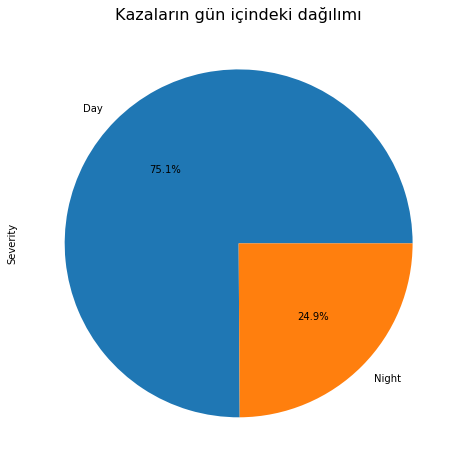

In [22]:
#Kazaların gün içi - gece dağılımı
explode = (0.1, 0)  # ilkini öne çıkar
plt.figure(figsize =(8,8))
df2.groupby(['Sunrise_Sunset'])['Severity'].size().sort_values(ascending=False).plot.pie(autopct='%1.1f%%')
plt.title('Kazaların gün içindeki dağılımı', fontsize=16)

Kazaların büyük bölümünün gün içinde olduğu görülüyor

Text(0.5, 1.0, 'Eyaletlere göre trafik kazası sayıları')

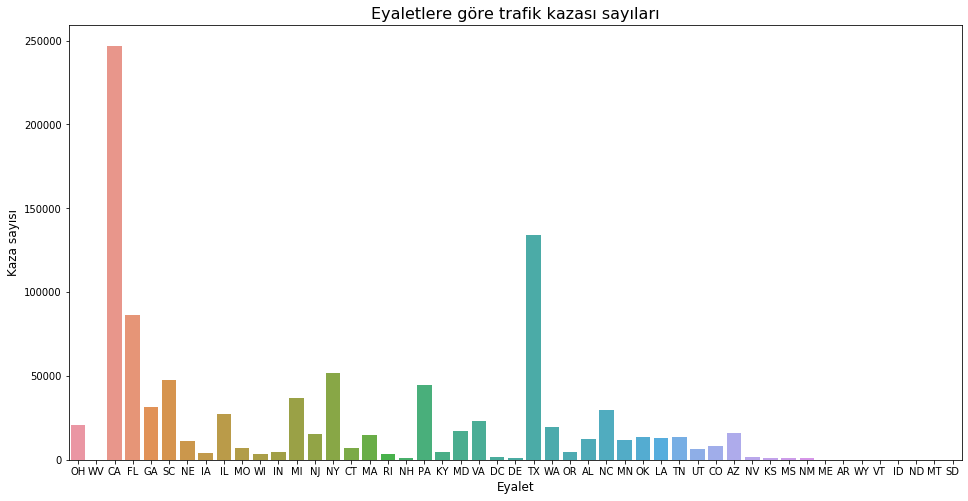

In [23]:
#Eyaletlere göre trafik kazası sayıları
states = df2.State.unique()
count_state = []
for i in states:
    count_state.append(df2[df2['State'] == i].count()['ID'])

plt.figure(figsize=(16,8))
sns.barplot(states, count_state)
plt.xlabel('Eyalet',fontsize=12)
plt.ylabel('Kaza sayısı',fontsize=12)
plt.title('Eyaletlere göre trafik kazası sayıları', fontsize=16)

Verilere göre, California en çok trafik kazasının yaşandığı şehir. Şehirlere göre kaza sayıları aşağıda da görülebilir

In [24]:
state_result= df2.groupby('State').count()
print('Eyalet ve kaza sayıları:\n ',state_result['ID'].sort_values(ascending=False))

Eyalet ve kaza sayıları:
  State
CA    247001
TX    133782
FL     86140
NY     52023
SC     47530
PA     44668
MI     36685
GA     31346
NC     29523
IL     27438
VA     22966
OH     20599
WA     19438
MD     17083
AZ     16042
NJ     15605
MA     14540
OK     13857
TN     13368
LA     12929
AL     12671
MN     11879
NE     11284
CO      8135
CT      7166
MO      7078
UT      6170
OR      4706
KY      4697
IN      4394
IA      3810
WI      3675
RI      3232
NV      1872
DC      1404
DE      1227
KS      1000
MS       966
NM       897
NH       877
AR        94
WV        84
VT        67
ID        20
WY        14
ME        13
ND         3
SD         1
MT         1
Name: ID, dtype: int64


In [25]:
#Hariada interaktif olarak eyalet ve kaza sayılarının gösterilmesi
df_st_ct = pd.value_counts(df2['State'])

fig = go.Figure(data=go.Choropleth(
    locations=df_st_ct.index,
    z = df_st_ct.values.astype(float),  
    locationmode = 'USA-states',
    colorscale = 'YlOrRd',
    colorbar_title = "Count",
))

fig.update_layout(
    title_text = 'Eyaletlere göre kazalar',
    geo_scope='usa', #Harita usa olsun
)

fig.show()

In [26]:
#Sehirlere göre kaza sayıları
city_count = df.groupby('County').count()
print('En çok kaza yapılan şehir : ',city_count.ID.idxmax())
print('Şehir ve kaza sayıları:\n ',city_count['ID'].sort_values(ascending=False))

En çok kaza yapılan şehir :  Los Angeles
Şehir ve kaza sayıları:
  County
Los Angeles    427
Mecklenburg    395
Wake           392
Harris         363
Davidson       280
              ... 
Mohave           1
Salem            1
Saline           1
Conecuh          1
Dickson          1
Name: ID, Length: 566, dtype: int64


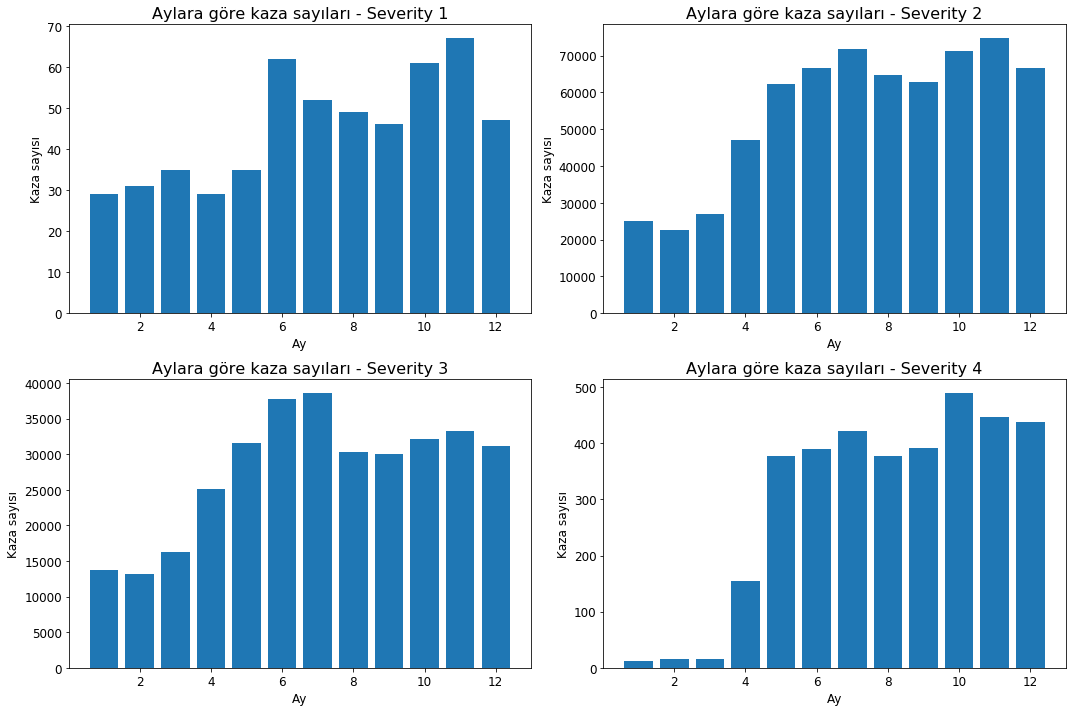

In [27]:
#Aylara göre severity kırılımlı kaza sayıları
df2['time'] = pd.to_datetime(df2.Start_Time, format='%Y-%m-%d %H:%M:%S')

plt.subplots(2,2,figsize=(15,10))
for s in np.arange(1,5):
    plt.subplot(2,2,s)
    plt.hist(pd.DatetimeIndex(df2.loc[df2["Severity"] == s]['time']).month, bins=[1,2,3,4,5,6,7,8,9,10,11,12,13], 
             align='left',rwidth=0.8)
    plt.title("Aylara göre kaza sayıları - Severity " + str(s), fontsize=16)
    plt.xlabel("Ay", fontsize=12)
    plt.ylabel("Kaza sayısı", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Elimizdeki verilere göre; yaz aylarının başlaması ile beraber, kaza sayılarında bir artış yaşandığı görülüyor.

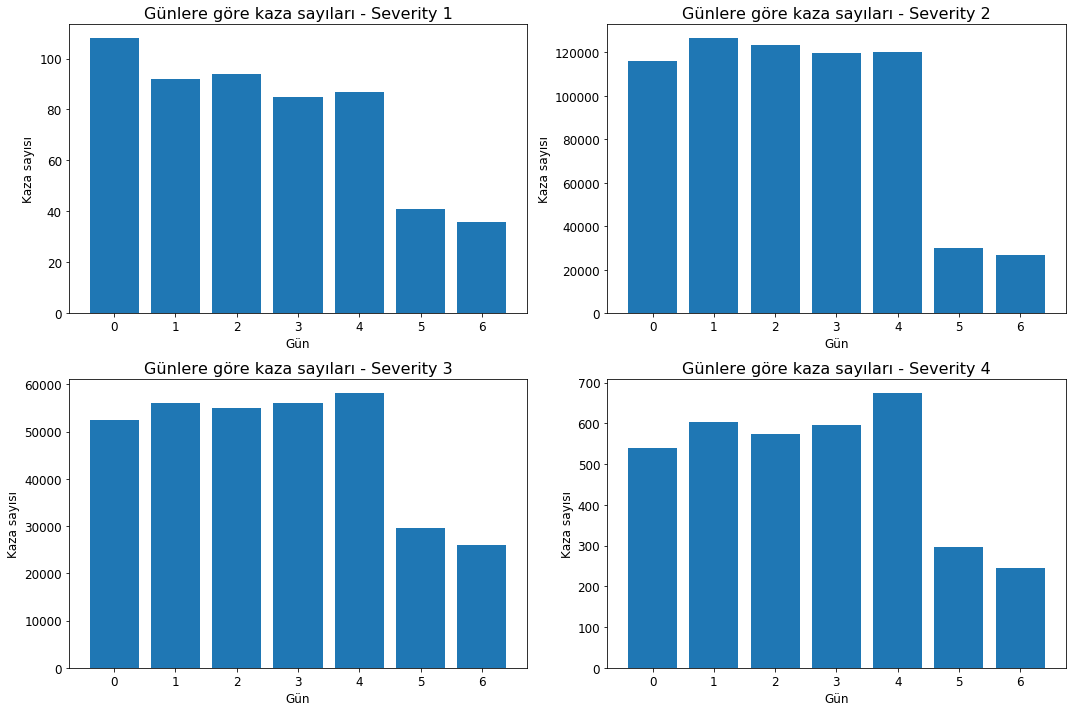

In [28]:
#Günlere göre severity kırılımlı kaza sayıları
df2['DayOfWeek'] = df2['time'].dt.dayofweek
plt.subplots(2,2,figsize=(15,10))
for s in np.arange(1,5):
    plt.subplot(2,2,s)
    plt.hist(df2.loc[df2["Severity"] == s]['DayOfWeek'], bins=[0,1,2,3,4,5,6,7], align='left', rwidth=0.8)
    plt.title("Günlere göre kaza sayıları - Severity " + str(s), fontsize=16)
    plt.xlabel("Gün", fontsize=12)
    plt.ylabel("Kaza sayısı", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Verilere göre, haftasonları kaza sayılarında önemli bir düşüş görülüyor.

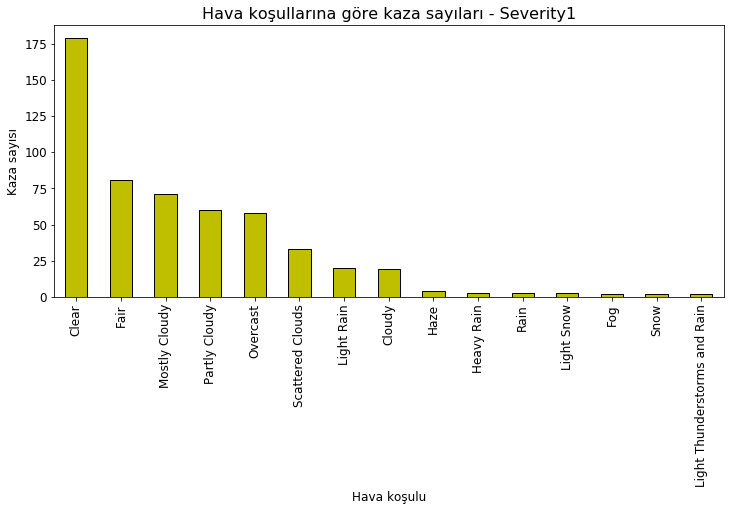

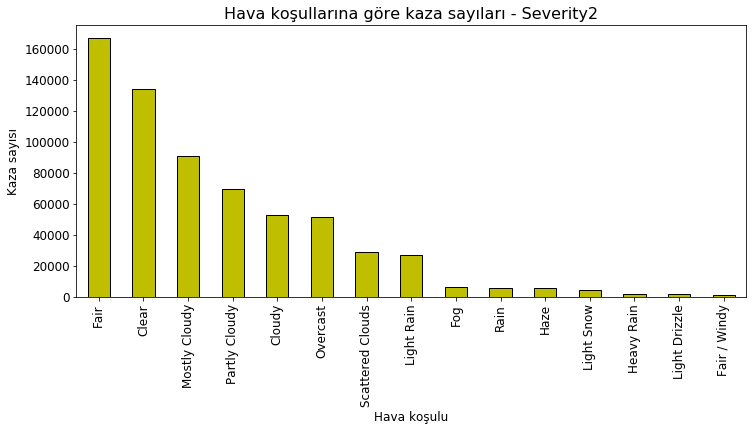

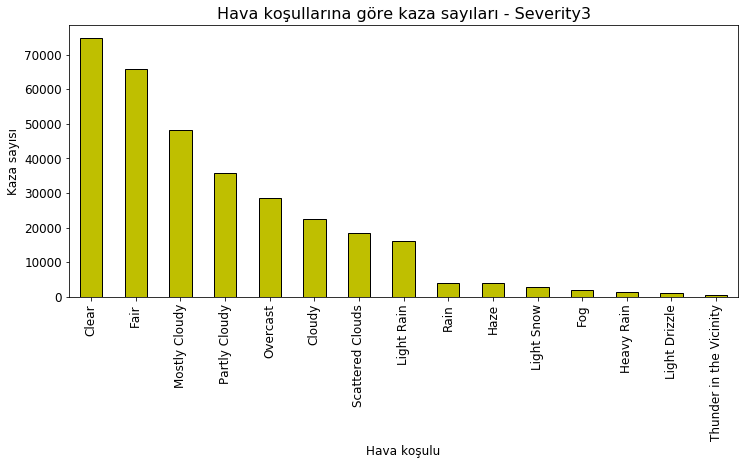

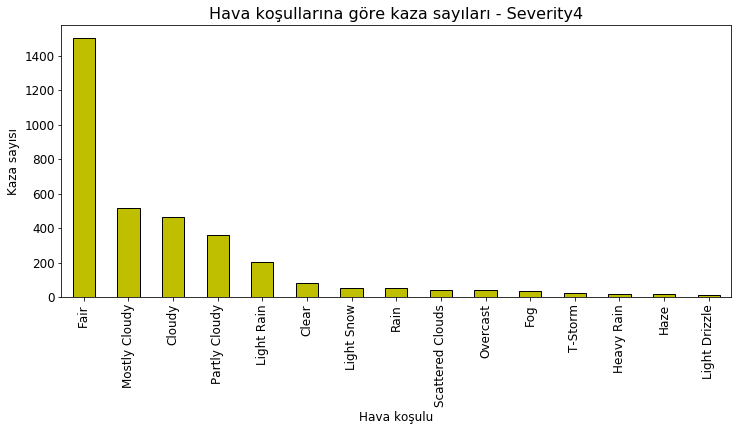

In [29]:
#Önemli 15 hava koşuluna göre severity kırılımlı kaza sayıları
for s in np.arange(1,5):
    plt.subplots(figsize=(12,5))
    df2.loc[df2["Severity"] == s]['Weather_Condition'].value_counts().sort_values(ascending=False).head(15).plot.bar(width=0.5,color='y',edgecolor='k',align='center',linewidth=1)
    plt.xlabel('Hava koşulu',fontsize=12)
    plt.ylabel('Kaza sayısı',fontsize=12)
    plt.title('Hava koşullarına göre kaza sayıları - Severity' + str(s),fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    Görüldüğü gibi, kazaların büyük çoğunluğu açık veya bulutlu havalarda meydana gelmiş. Bu hava koşulları yağmur veya kar ile karşılaştırıldığında daha tehlikesizler, ancak en sık karşılaşılan hava koşulları bunlar.  Hafif yağmur ve hafif kar durumlarında ise kaza sayıları yağmur / kara göre daha yüksek, bunun nedeni ise, yolun daha kaygan olması, ancak buna rağmen sürücülerin pek dikkatli olmamaları diye düşünülebilir. 

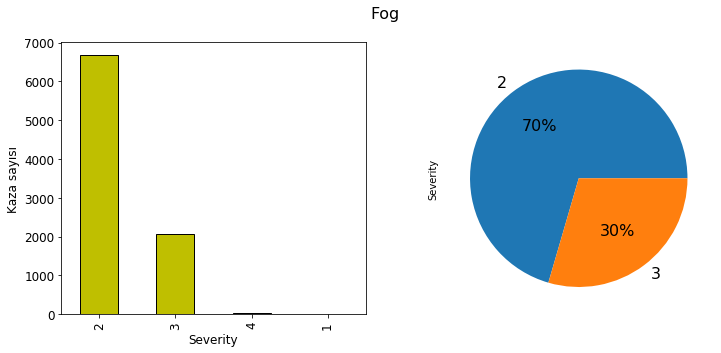

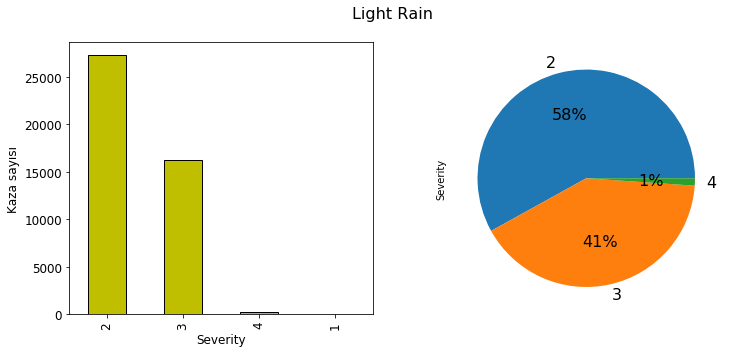

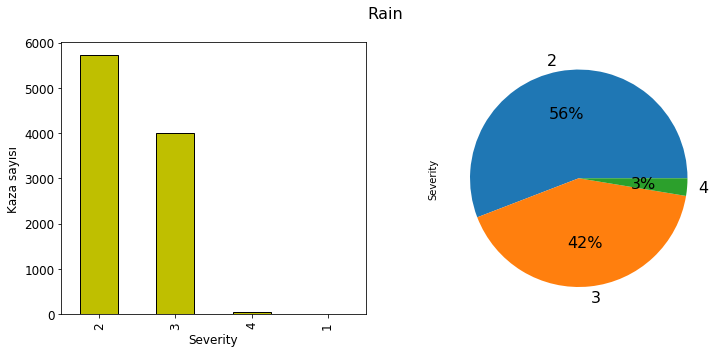

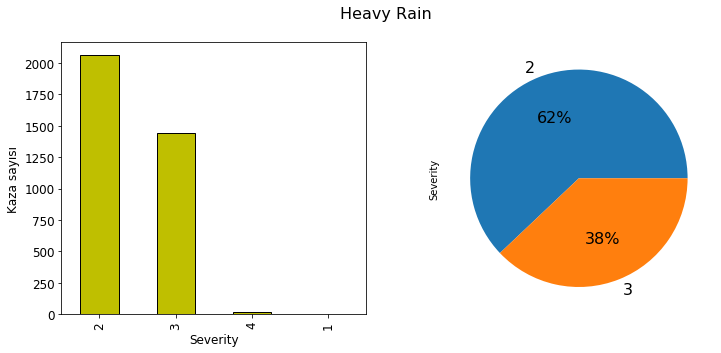

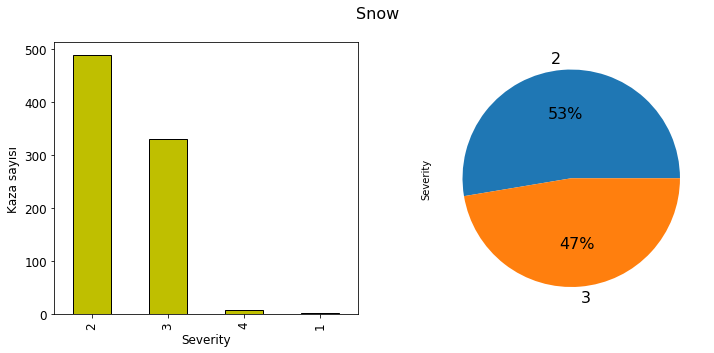

In [30]:
#Çeşitli hava koşulları altında kaza şiddet dağılımları
explode = (0, 0.1, 0, 0)  # 2 yi öne çıkar
for s in ["Fog","Light Rain","Rain","Heavy Rain","Snow"]:
    plt.subplots(1,2,figsize=(12,5))
    plt.suptitle(s, fontsize=16)
    plt.subplot(1,2,1)
    df2.loc[df2["Weather_Condition"] == s]['Severity'].value_counts().plot.bar(width=0.5,color='y',edgecolor='k',align='center',linewidth=1)
    plt.xlabel('Severity',fontsize=12)
    plt.ylabel('Kaza sayısı',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.subplot(1,2,2)
    df.loc[df["Weather_Condition"] == s]['Severity'].value_counts().plot.pie(autopct='%1.0f%%',fontsize=16)

In [31]:
#Start_Time kolonunun parse edilmesi
df2['Start_Time']= pd.to_datetime(df2['Start_Time'])
df2['End_Time'] = pd.to_datetime(df2.End_Time)
df2['hour']= df2['Start_Time'].dt.hour
df2['year']= df2['Start_Time'].dt.year
df2['month']= df2['Start_Time'].dt.month
df2['week']= df2['Start_Time'].dt.week
df2['quarter']= df2['Start_Time'].dt.quarter
df2['time_zone']= df2['Start_Time'].dt.tz
df2['time']= df2['Start_Time'].dt.time

In [32]:
#Kaza süresini hesaplama
df2['duration'] = df2['End_Time'] - df2['Start_Time']
df2['duration'] = np.round(df2['duration']/np.timedelta64(1,'m'), 1)

In [33]:
df2[['Start_Time', 'End_Time',  'duration']]

Start_Time            End_Time  duration
0      2016-02-08 05:46:00 2016-02-08 11:00:00     314.0
1      2016-02-08 06:07:59 2016-02-08 06:37:59      30.0
2      2016-02-08 06:49:27 2016-02-08 07:19:27      30.0
3      2016-02-08 07:23:34 2016-02-08 07:53:34      30.0
4      2016-02-08 07:39:07 2016-02-08 08:09:07      30.0
...                    ...                 ...       ...
999995 2019-04-13 14:38:49 2019-04-13 15:38:13      59.4
999996 2019-04-13 16:28:22 2019-04-13 17:27:49      59.4
999997 2019-04-13 16:54:37 2019-04-13 18:41:29     106.9
999998 2019-04-13 18:23:47 2019-04-13 19:08:25      44.6
999999 2019-04-13 18:25:53 2019-04-13 19:09:39      43.8

[1000000 rows x 3 columns]

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.]),
 <a list of 7 Text yticklabel objects>)

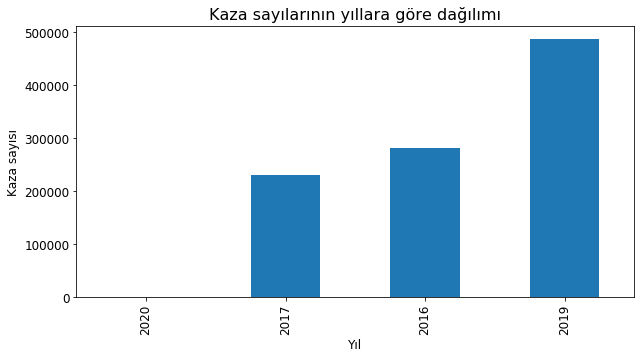

In [34]:
#Kaza sayılarının yıllara göre dağılımı
plt.figure(figsize =(10,5))
df2.groupby(['year']).size().sort_values(ascending=True).plot.bar()
plt.title('Kaza sayılarının yıllara göre dağılımı',fontsize=16)
plt.xlabel('Yıl',fontsize=12)
plt.ylabel('Kaza sayısı',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Kaza sayılarının 2019'da arttığı görülüyor.

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.]),
 <a list of 7 Text yticklabel objects>)

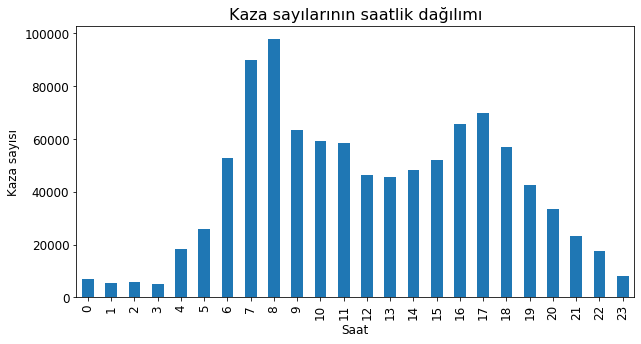

In [35]:
#Kaza sayılarının saatlik dağılımı
plt.figure(figsize =(10,5))
df2.groupby(['hour']).size().plot.bar()
plt.title('Kaza sayılarının saatlik dağılımı',fontsize=16)
plt.xlabel('Saat',fontsize=12)
plt.ylabel('Kaza sayısı',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Kazaların en çok mesai başlangıcında işe gidiş sırasında yapıldığı görülüyor

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000., 400000., 450000.]),
 <a list of 10 Text yticklabel objects>)

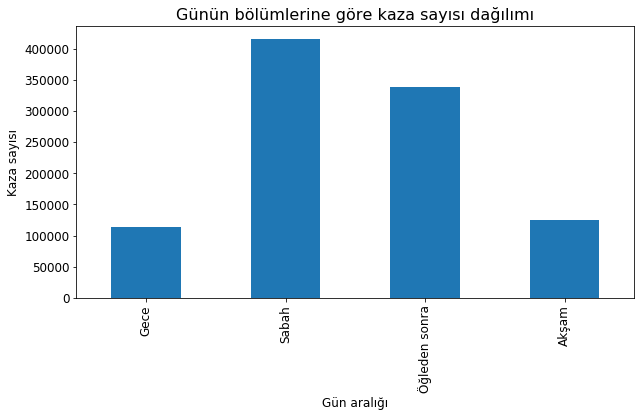

In [36]:
#Günün bölümlerine göre kaza sayısı dağılımı
df2['day_zone'] = pd.cut((df2['hour']),bins=(0,6,12,18,24), labels=["Gece", "Sabah", "Öğleden sonra", "Akşam"])
plt.figure(figsize =(10,5))
df2.groupby(['day_zone']).size().plot.bar()
plt.title("Günün bölümlerine göre kaza sayısı dağılımı", fontsize=16)
plt.xlabel("Gün aralığı", fontsize=12)
plt.ylabel("Kaza sayısı", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Grafiğe göre, kazaların genellikle 06:00 - 18:00 saatleri arasında yapıldığı görülüyor.

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000., 800000., 900000.]),
 <a list of 10 Text yticklabel objects>)

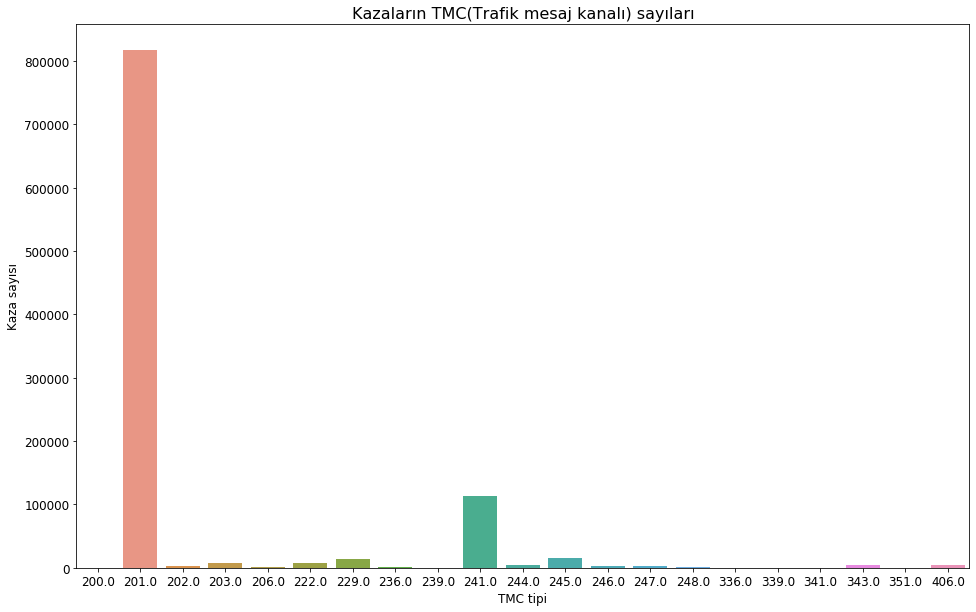

In [37]:
#Kazaların TMC(Trafik mesaj kanalı) sayıları
TMC_counts=df2.TMC.value_counts()
plt.figure(figsize=(16, 10))
sns.barplot(TMC_counts.index, TMC_counts)
plt.title("Kazaların TMC(Trafik mesaj kanalı) sayıları", fontsize=16)
plt.xlabel("TMC tipi", fontsize=12)
plt.ylabel("Kaza sayısı", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



En çok görülen mesaj kanalının 201 yani (Q) accident olduğu görülüyor

In [38]:
start = pd.to_datetime(df2.Start_Time, format='%Y-%m-%d %H:%M:%S')
end = pd.to_datetime(df2.End_Time, format='%Y-%m-%d %H:%M:%S')
duration=end-start

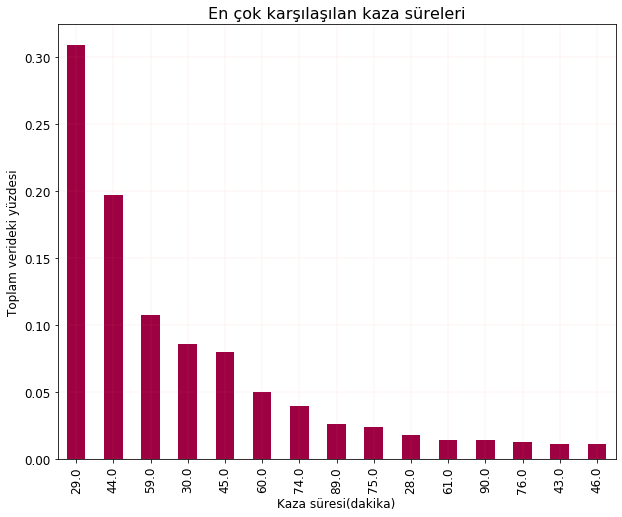

In [39]:
#en çok karşılaşılan kaza süreleri
top_15 = duration.astype('timedelta64[m]').value_counts().nlargest(15) #Return the first 
plt.figure(figsize=(12, 8))
(top_15/top_15.sum()).plot.bar(figsize=(10,8), colormap='Spectral')
plt.title('En çok karşılaşılan kaza süreleri', fontsize=16)
plt.xlabel('Kaza süresi(dakika)', fontsize=12)
plt.ylabel('Toplam verideki yüzdesi', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle=':', linewidth = '0.2', color ='salmon');

In [40]:
#Weather verisini çekip nan verileri temizliyoruz
weatherdata = df2['Weather_Condition'].dropna()

In [41]:
 #Weather_Conditions kolonundaki boşlukları temizleme
def processText(text):
    try:
        textlist = text.split('/')
        for i in range(len(textlist)):
            textlist[i]=textlist[i].split(' ')
            if '' in textlist[i]:
                textlist[i].remove('')
            textlist[i] = ''.join(textlist[i])
        text = '/'.join(textlist)
        return text
    except Exception as e:
        print(text)
        print(e)

In [42]:
#tüm veri seti Weather_Condition için fonksiyon çalıştırılması
weatherdata = weatherdata.apply(processText)

In [43]:
#Verideki Weather_Conditions değerlerinin bir listeye alınması
text = ' '.join(weatherdata.values.tolist())
wordcloud = WordCloud(background_color="white").generate(text)

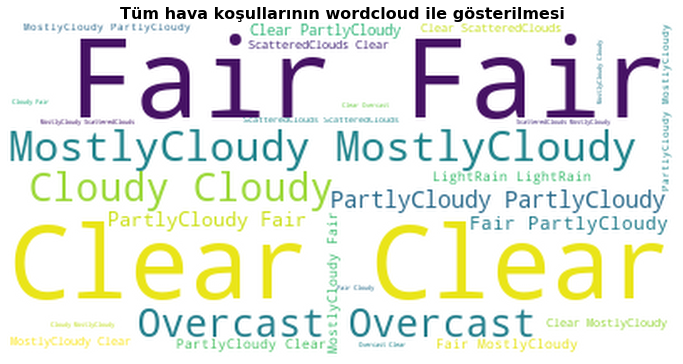

In [44]:
#En sık karşılaşılan hava koşulu büyük, en az karşılaşılan küçük olacak şekilde wordcloud imshow gösterimi
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Tüm hava koşullarının wordcloud ile gösterilmesi',fontdict={'fontsize': 16, 'fontweight' : 'bold', 'verticalalignment': 'center', 'horizontalalignment': 'center'})
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis("off")
plt.show()

In [50]:
#knime prediction icin kullanılaak python scriptte severity aşağıdaki gibi kategorize edilecek

In [51]:
#Severity transformation
Severity_mapping = {1 : 'low', 2: 'low', 3: 'High', 
               4: 'High'}
df2['Severity_transformed'] = df2['Severity'].map(Severity_mapping)

In [52]:
# mapping'in sağlaması'
df2.Severity_transformed.value_counts()

low     663118
High    336882
Name: Severity_transformed, dtype: int64

In [53]:
df2.Severity.value_counts()

2    662575
3    333354
4      3528
1       543
Name: Severity, dtype: int64

In [54]:
df2.drop(['Severity'], axis=1, inplace=True)